# Predicting the popularity of a song using the Spotify Dataset

In [1]:
!pip install pydotplus
!pip install six

In [2]:
!pip install plotnine

In [3]:
!pip install pydot

In [4]:
!pip install graphviz

In [5]:
#Gets rid of warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# General tools
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, HTML
from plotnine import *
import pydot
from plotnine import *
from tqdm import tqdm
import pydotplus


# For transformations and predictions
from scipy.optimize import curve_fit
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from six import StringIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

## Cleaning and Preprocessing of Data
This section was done in the Exploratory Data Analysis File. I decided to separate my Jupyter Notebooks to test models and to create a final notebook that will have the best results in it. 

In [7]:
#Reading in dataset
df = pd.read_csv('data.csv')
#Dropping columns
df = df.drop(['id'], axis = 1)
df = df.drop(['name'], axis = 1)
df = df.drop(['release_date'], axis = 1)
#Removal of duplicates
df = df[~df.duplicated()==1]
#Takes the names of columns
cols = list(df)
x = df.drop('popularity', axis = 1)
y = df['popularity']
#Splitting up the x and y into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 42)

In this case there is quite a few features that need to be preprocessed. 

In [8]:
class ArtistsTransformer():
 """"
      PARAMETERS:
      ----------
      MinCnt (int): Minimal treshold of artisits apear in dataset, default = 3
      MaxCnt (int): Maximal treshold of artisits apear in dataset, default = 600
      RERTURN:
      ----------
      A DataFrame with converted artists str feature to floats
  """

  def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
      self.MinCnt = MinCnt
      self.MaxCnt = MaxCnt
      self.artists_df = None
  
  def fit (self, X, y):
      self.artists_df =  y.groupby(X.artists).agg(['mean', 'count'])
      self.artists_df.loc['unknown'] = [y.mean(), 1]
      self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
      self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
      return self

  def transform(self, X, y=None):
      X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
      X['artists'] = X['artists'].map(self.artists_df['mean'])
      return X

In [9]:
# Apply AritistsTransformer on train and test seperatly
artists_transformer = ArtistsTransformer(MinCnt=2)
x_train = artists_transformer.fit(x_train, y_train).transform(x_train, y_train)
x_test = artists_transformer.transform(x_test, y_test)

In [10]:
def instrumentalness_criteria(X):
    X['instrumentalness'] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.instrumentalness))

instrumentalness_tranformer = FunctionTransformer(instrumentalness_criteria)
instrumentalness_tranformer.transform(x_train)
instrumentalness_tranformer.transform(x_test)

In [11]:
class ReplaceZeroTransformer():

    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X

In [12]:
tempo_transformer = ReplaceZeroTransformer()
x_train = tempo_transformer.transform(x_train)
x_test = tempo_transformer.transform(x_test)

In [13]:
OneHot = OneHotEncoder(categories='auto', drop='first')

# Train
feature_arr = OneHot.fit_transform(x_train[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(x_train['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(x_train['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_arr, columns = feature_labels, index = x_train.index)
x_train = pd.concat([x_train, features], axis=1).drop(['key','instrumentalness'], axis=1)

# Test
feature_arr = OneHot.fit_transform(x_test[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(x_test['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(x_test['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_arr, columns = feature_labels, index = x_test.index)
x_test = pd.concat([x_test, features], axis=1).drop(['key','instrumentalness'], axis=1)

## Min Max Scaler

In [35]:
MinMax = MinMaxScaler()
cols = ['artists','duration_ms','loudness','tempo']
x_train[cols] = MinMax.fit_transform(x_train[cols])
x_test[cols] = MinMax.fit_transform(x_test[cols])

In [15]:
# Divide the popularity by 100
y_train = y_train / 100
y_test = y_test / 100

## Verification

In [16]:
nl = '\n'
print(f'X_train shape is: {x_train.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test shape is: {x_test.shape} {nl}y_test shape is: {y_test.shape}')

X_train shape is: (136749, 26) 
y_train shape is: (136749,) 
X_test shape is: (34188, 26) 
y_test shape is: (34188,)


In [17]:
x_train.head(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,liveness,loudness,mode,speechiness,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,ins_2,ins_3
140722,0.00091,0.077744,0.484,0.052496,0.8950,0,0.311,0.782084,0,0.0492,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
83785,0.38700,0.474046,0.274,0.058661,0.3170,0,0.103,0.734430,1,0.0286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
32075,0.95900,0.415086,0.231,0.053599,0.0698,0,0.157,0.547428,1,0.0436,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
x_train.describe().drop(['count','25%', '50%', '75%'])

,acousticness,artists,danceability,duration_ms,energy,explicit,liveness,loudness,mode,speechiness,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,ins_2,ins_3
mean,0.501143,0.319745,0.536038,0.042680,0.48122,0.068052,0.211632,0.755307,0.704897,0.105792,...,0.108871,0.041785,0.075884,0.095686,0.052490,0.122334,0.061975,0.103365,0.071094,0.062955
std,0.378768,0.205066,0.175691,0.027276,0.27148,0.251835,0.180881,0.088826,0.456091,0.183092,...,0.311478,0.200097,0.264813,0.294162,0.223014,0.327672,0.241111,0.304436,0.256982,0.242882
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.996000,1.000000,0.988000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.970000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
y_train.describe().drop(['count','25%', '50%', '75%'])

mean    0.261793
std     0.218470
min     0.000000
max     1.000000
Name: popularity, dtype: float64

# Models

# Linear Regression

## Features that only have a correlation coefficient greater than 0.2

In [20]:
LR = LinearRegression()
cols = [col for col in x_train.columns if abs(x_train[col].corr(y_train))>0.2]

# Fit the model and
LR.fit(x_train.drop(columns=cols), y_train)

# Train Predicting with the model
y_train_pred = LR.predict(x_train.drop(columns=cols)).clip(0, 1)

# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.5f}")

#Predicting with the model
y_test_pred = LR.predict(x_test.drop(columns=cols)).clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Test = {LR_rmse:.5f}")

RMSE Train = 0.20227
RMSE Test = 0.20264


## All Features

In [21]:
LR = LinearRegression()

# Fit the model and
LR.fit(x_train, y_train)

# Train Predicting with the model
y_train_pred = LR.predict(x_train).clip(0, 1)

# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.6f}")

#Predicting with the model
y_test_pred = LR.predict(x_test).clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Test = {LR_rmse:.6f}")

RMSE Train = 0.131118
RMSE Test = 0.138046


In [22]:
from IPython.display import display, Math

def get_printable_equt(df, inter, coef):
  equation = '$y = ' + f'{inter:.2f} '
  
  for i, co in enumerate(coef):
    if i == len(coef) - 1:
        equation = equation + f'+ {co:.2f} {(df.columns)[i]}$'
    else:
        equation = equation + f'+ {co:.2f} {(df.columns)[i]}'

  return display(Math(equation))

get_printable_equt(x_train, LR.intercept_, LR.coef_)

<IPython.core.display.Math object>

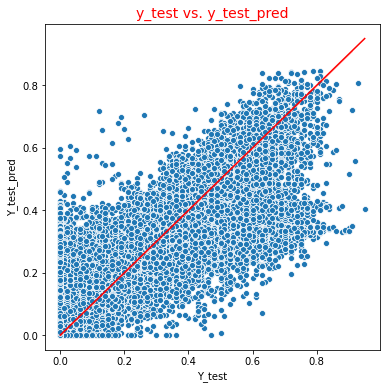

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

# K Nearest Neighbor Model

In [30]:
RMSE1_train, RMSE1_test = [], []
  
for i in range(5,101,5):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(x_train,y_train)
  y_train_pred = knn.predict(x_train)
  knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))
  RMSE1_train.append(knn_train_rmse.round(3))
  y_test_pred = knn.predict(x_test)
  knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))
  RMSE1_test.append(knn_test_rmse.round(3))

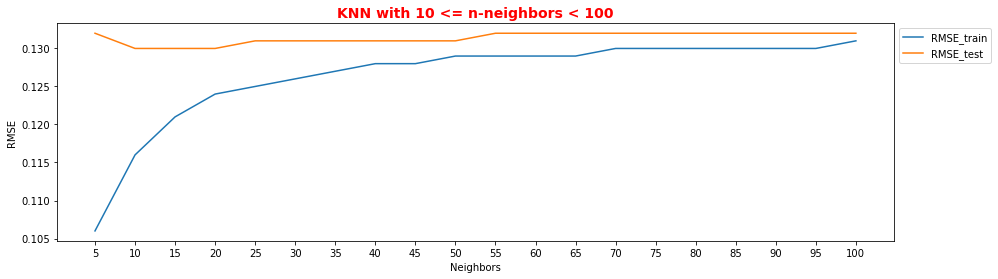

In [31]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(5, 101, 5)
ax = sns.lineplot(x=x, y=RMSE1_train)
sns.lineplot(x=x, y=RMSE1_test, ax=ax)
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Neighbors')
ax.set_ylabel('RMSE')
ax.set_xticks(np.arange(5,101,5))
ax.set_title('KNN with 10 <= n-neighbors < 100', c='r', fontdict={'c':'r', 'fontsize':14, 'weight':'bold'})
plt.show()

In [33]:
gap2 = [RMSE1_test[num]-RMSE1_train[num] for num, i in enumerate(RMSE1_train)]
print(f'RMSE Train: {RMSE1_train[gap2.index(min(gap2))]}, RMSE_test: {RMSE1_test[gap2.index(min(gap2))]}')

RMSE Train: 0.131, RMSE_test: 0.132


# Decision Tree Model

In [37]:
# single run
tree = DecisionTreeRegressor(max_leaf_nodes=41, min_samples_split=2000)
tree.fit(x_train, y_train)
y_train_pred = tree.predict(x_train).clip(0, 1)
train_rmse = np.sqrt(mse(y_train, y_train_pred))
y_test_pred = tree.predict(x_test).clip(0, 1)
test_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f'train RMSE: {train_rmse}')
print(f'test RMSE: {test_rmse}')

train RMSE: 0.11088731154871138
test RMSE: 0.11508154868162794


In [25]:
RMSE3_train, RMSE3_test = [], []

for i in range(2,200):
  tree = DecisionTreeRegressor(random_state = 15, max_leaf_nodes=i)
  tree.fit(x_train, y_train)
  y_train_pred = tree.predict(x_train).clip(0, 1)
  train_rmse = np.sqrt(mse(y_train, y_train_pred))
  RMSE3_train.append(train_rmse.round(3))
  y_test_pred = tree.predict(x_test).clip(0, 1)
  test_rmse = np.sqrt(mse(y_test, y_test_pred))
  RMSE3_test.append(test_rmse.round(3))

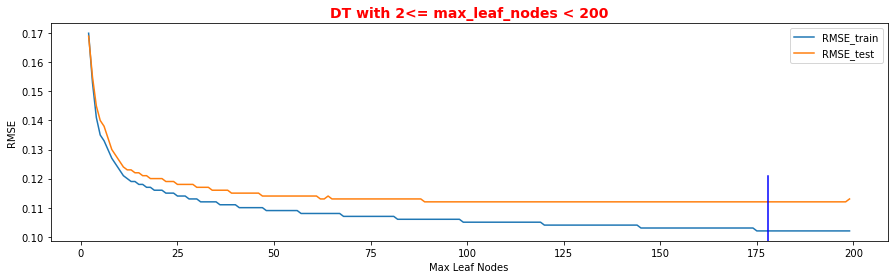

In [26]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(2, 200)
ax = sns.lineplot(x=x, y=RMSE3_train)
sns.lineplot(x=x, y=RMSE3_test, ax=ax)
ax.axvline(x=178, ymin=0, ymax=0.3, color='blue')
# ax.axvline(x=139, ymin=0.5, ymax=0.8, color='orange')
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Max Leaf Nodes')
ax.set_ylabel('RMSE')
ax.set_title('DT with 2<= max_leaf_nodes < 200', c='r', fontdict={'c':'r', 'fontsize':14, 'weight':'bold'})
plt.show()

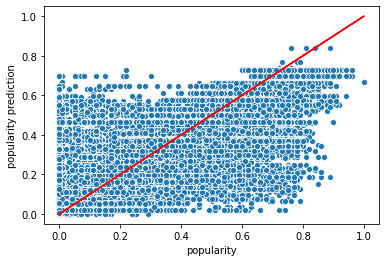

In [27]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
ax.set_ylabel('popularity prediction')
plt.show()

In [28]:
gap3 = [(RMSE3_train[i]/RMSE3_test[i]) for i, num in enumerate(RMSE3_train)]

print(f'Minimum validiation is: {min(gap3):.3%} in index number {gap3.index(min(gap3))}')
print(f'Maximum validiation is: {max(gap3):.3%} in index number {gap3.index(max(gap3))}')

Minimum validiation is: 90.265% in index number 197
Maximum validiation is: 100.592% in index number 0


In [29]:
print('Feature importances:')
for i, col in enumerate(x_train.columns):
  print(f'{col:12}: {tree.feature_importances_[i]:.3f}')

Feature importances:
acousticness: 0.008
artists     : 0.305
danceability: 0.005
duration_ms : 0.010
energy      : 0.006
explicit    : 0.017
liveness    : 0.003
loudness    : 0.008
mode        : 0.000
speechiness : 0.002
tempo       : 0.003
valence     : 0.002
year        : 0.612
key_1       : 0.019
key_2       : 0.000
key_3       : 0.000
key_4       : 0.000
key_5       : 0.000
key_6       : 0.000
key_7       : 0.000
key_8       : 0.000
key_9       : 0.000
key_10      : 0.000
key_11      : 0.000
ins_2       : 0.000
ins_3       : 0.000


In [36]:
#My attempt to print out the decision tree
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,feature_names=x_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found